# Exploration08_ human image segmentation
>date: 25 oct 2021<br>
author : benjamin<br>
e-mail : naroo135@gmail.com

## overview
  사람은 시각 정보에 대해서 모든 내용들을 한꺼번에 인지하지 못한다. 사람이 보고 있는 대상들에 대해서 주의를 끄는 부분에 대해서 선명하게 인지한다. 예를 들면 농구경기를 볼 때 사람들은 선수 개개인을 실시간으로 모두 의식하여 보지 않는다. 주로 농구공의 움직임, 농구공을 소유하고 있는 선수, 각 팀들의 포메이션 등에 대해서 주의를 기울여 의식한다. 주의를 기울이지 않는 그 외의 시각 정보들에 대해선 의식영역의 밖으로 취급한다. 이러한 주의의 한계에 대해서 계획적이지 않은 촬영 이미지들은 중요한 피사체(대상)에 대해서 주의를 기울이는데 적합하지 않을 수 있다. 인물을 촬영하는데 주변의 난잡한 이미지들은 인물에 대해서 주의를 기울이는데 방해요소로 작용하며 인물 자체에 대해서 주의를 충분히 이끌지 못한다. 따라서 이번 exploraration은 인물과 같은 target image외에 다른 이미지 정보들의 영향력을 감소시키기 위해 target img외에 이미지들을 blur처리하여 배경으로 간주하여 광학적 도구 없이 얉은 심도를 구현해볼 목적이다.



## required module
  `DeepLabModel` class<br>
  `tarfile` module<br>
  `pretrained weight`



## function list

func01 : ImgMask<br>
func02 : MaskUp<br>
func03 : imgblur<br>
func04 : Cropperson<br>
func05 : combine_img<br>

### Work(0) : jupyter notebook env configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab_ML/LMS_/EXP08_segmentation')

### Work(1) : img loading

image를 3개 선정해볼 것이다. 첫번째 이미지는 비교적 segementation처리를 위해 target image를 분류하는데 비교적 구분이 쉬운 이미지로 선정할 것이다.
두번째와 세번째 이미지는 target image와 그렇지 않은 이미지의 경계가 모호하거나 복잡한 이미지를 선정할 것이다. 이러한 이미지를 선정한 이유는 deeplab의 성능과 문제점을 파악하고 개선의 방향을 알아바고자 함이다.

첫번째 이미지는 배우 '양혜지'이미지로써 

In [ ]:
import cv2
import numpy as np
import os
import tarfile
import urllib
import pandas as pd

from matplotlib import pyplot as plt
import tensorflow as tf

In [ ]:
img_name = ['low','med','high']
img_dict = {}

for index in img_name:
    img_dict[index] = cv2.imread('sample_complex_'+index+ '.jpg')
    print(img_dict[index].shape)

(1080, 1920, 3)
(960, 640, 3)
(333, 500, 3)


### Work(2) : definition of deeplab model class and img processing functions


In [ ]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [ ]:
# person img를 찾아 masking하는 함수

def ImgMask(img_dict,img_resized,seg_map):
    img_orig = img_dict
    img_show = img_resized.copy()
    seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
    img_mask = seg_map * (255/seg_map.max()) # 255 normalization
    img_mask = img_mask.astype(np.uint8)
    color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
    img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

    fig = plt.figure()
    nrows = 1
    ncols = 2

    axe1 = fig.add_subplot(nrows,ncols,1)
    axe1.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    axe1.set_title('original img')

    axe2 = fig.add_subplot(nrows,ncols,2)
    axe2.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    axe2.set_title('extracted img')

    return img_mask

In [ ]:
# 축소된 이미지를 inter_linear interpolation하여 원래 크기로 변환하는 함수

def MaskUp(img_mask,img_dict):
    img_orig = img_dict
    img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
    _, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

    ax = plt.subplot(1,2,1)
    plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
    ax.set_title('Original Size Mask')

    ax = plt.subplot(1,2,2)
    plt.imshow(img_mask, cmap=plt.cm.binary_r)
    ax.set_title('DeepLab Model Mask')

    plt.show()

    return img_mask_up

In [ ]:
def imgblur(img_orig):
    img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()
    print(len(img_orig_blur))
    return img_orig_blur

In [ ]:
def CropPerson(img_mask_up,img_orig_blur):
    img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

    return img_bg_blur,img_mask_color

In [ ]:
def combine_img(img_orig,img_bg_blur,img_mask_color):
    img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()
    return cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB)

### work(3) : getting of pretrained weight from google

In [ ]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '/content/drive/MyDrive/Colab_ML/LMS_/EXP08_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /content/drive/MyDrive/Colab_ML/LMS_/EXP08_segmentation/models
model loaded successfully!


### work(4) : img resize

In [ ]:
img_resized = {}
seg_map = {}

for index in img_dict.keys():
    img_resized[index], seg_map[index] = MODEL.run(img_dict[index])
    print (img_dict[index].shape, img_resized[index].shape, seg_map[index].max())

(1080, 1920, 3) (288, 513, 3) 20
(960, 640, 3) (513, 342, 3) 15
(333, 500, 3) (341, 513, 3) 15


### work(5) : masking of 'person' class img 

In [ ]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [ ]:
img_dict.keys()

dict_keys(['low', 'med', 'high'])

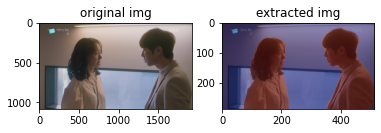

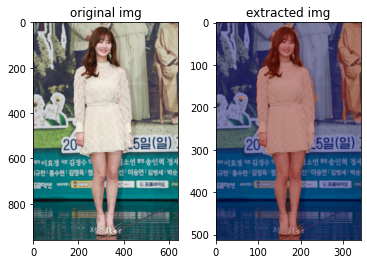

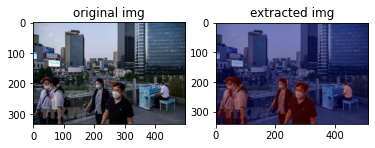

In [ ]:
img_mask = {}
for index in img_dict.keys():
    img_mask[index] = ImgMask(img_dict[index],img_resized[index],seg_map[index])


### work(6) : img scale up with interpoloaration

  처리된 이미지를 다시 원래 사이즈로 돌리기 위해선 픽셀 수를 증가시켜야 한다. 처리된 이미지의 픽셀 수를 몇 배 증가시킨다고 할 때 빈 공간의 픽셀이 점유하게 된다. 이 빈 공간이 아무런 픽셀 값이 주어지지 않을 때 모자이크와 같은 부자연스러운 이미지로 확대될 것이다. 이러한 문제에 대해서 빈 픽셀에 대해 적절한 픽셀값을 채워야 자연스러운 이미지로 확대할 수 있다. 자연스러운 이미지로 확대하기 위해선 보간(interpoloaration)의 기법들을 이용할 수 있다. 이 exploraration에서는 `cv2.INTER_LINEAR`의 interpoloartion을 이용하였다.
  
  

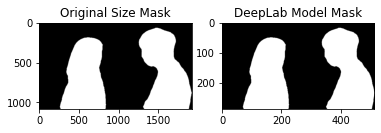

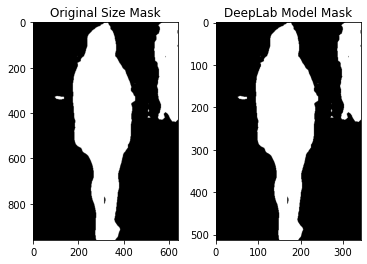

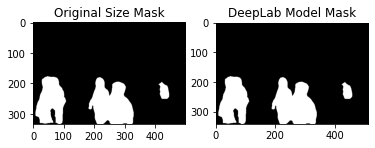

In [ ]:
Maskup_dict = {}
for index in img_dict.keys():
    Maskup_dict[index] = MaskUp(img_mask[index],img_dict[index])

## >>find problems

'mask처리와 person'과 그렇지 않는 이미지를 흰색(255값)과 검은색(0값)으로 분류하였을 때 위 이미지들이 segmentation을 얼마나 잘 수행하였는지 시각적으로 살펴볼 수 있다. 현재까지 관찰된 문제점은 크게 2가지이다.<br> 

첫번째는 segmentation의 오인문제이다. 가장 복잡성이 덜한 첫번째 이미지는 대체적으로 경계가 매끄럽고 인물과 배경을 잘 구분지은 모습을 보여준다. 하지만 2번째 사진에서는 '양혜지'인물 외에 사람이라고 잘못 segmentation된 부분들이 관찰된다. 왼쪽 조그마한 영역과 오른쪽 상단 조각상의 이미지를 person으로 segmentation하였다.<br>

두번째 문제는 경계의 영역의 명확성이다. mask처리된 2번째 사진에서 인물의 segmentation경계는 매끄럽지 못하며 어린아이가 갑자기 집중력을 잃고 그림그리기를 망친듯한 결과물을 보여준다. 또한 다리 사이에 사람 다리와 그렇지 않은 부분을 구분짓는 명확성이 다소 떨어진다.<br>

### work(7) : img blurring and combining of person img and blurred background

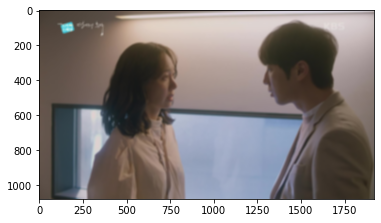

1080


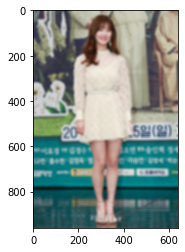

960


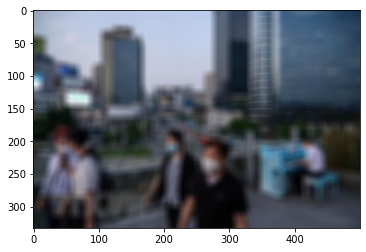

333


In [ ]:
img_orig_blur_dict = {}
for index in img_dict.keys():
    img_orig_blur_dict[index] = imgblur(img_dict[index])

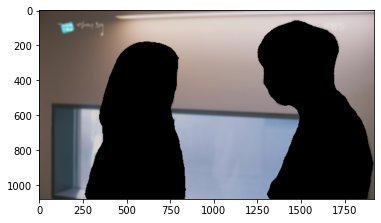

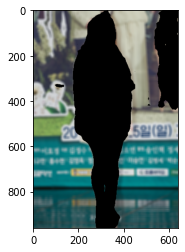

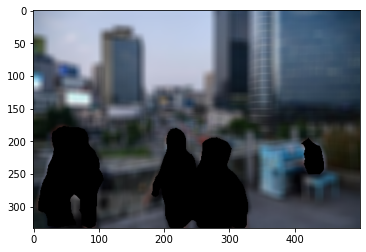

In [ ]:
img_bg_blur_dict = {}
img_mask_color_dict = {}
for index in img_dict.keys():
    img_bg_blur_dict[index],img_mask_color_dict[index] = CropPerson(Maskup_dict[index],img_orig_blur_dict[index])

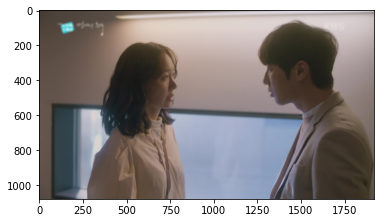

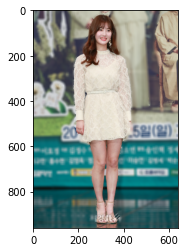

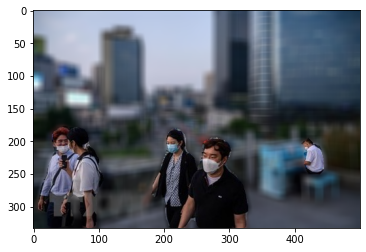

In [ ]:
combine_img_dict = {}
for index in img_dict.keys():
    combine_img_dict[index] = combine_img(img_dict[index],img_bg_blur_dict[index],img_mask_color_dict[index])

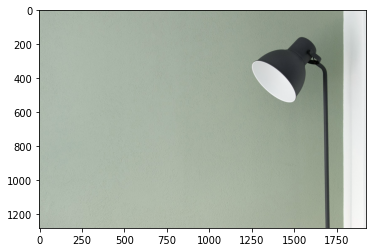

In [102]:
background_img = cv2.imread('background.jpg')
back_img1 = cv2.resize()

In [119]:
#cv2.resize(src, dsize=(640, 480), interpolation=cv2.INTER_AREA
back_img = {}

for index in img_dict.keys():
    height, width, channel = img_bg_blur_dict[index].shape
    print(height, width)
    back_img[index] = cv2.resize(background_img,dsize=(width,height),interpolation=cv2.INTER_AREA)
    print(back_img[index].shape)

1080 1920
(1080, 1920, 3)
960 640
(960, 640, 3)
333 500
(333, 500, 3)


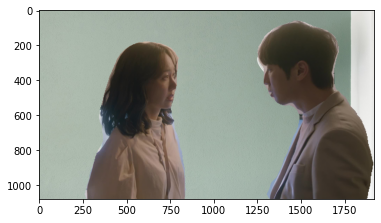

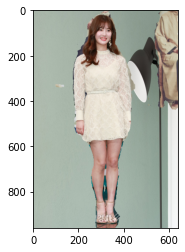

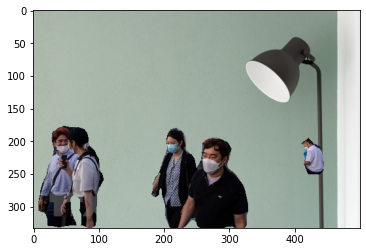

In [120]:
combine_img_dict = {}
for index in img_dict.keys():
    combine_img_dict[index] = combine_img(img_dict[index],back_img[index],img_mask_color_dict[index])

### work(8) : problem region

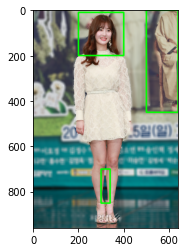

In [ ]:
img_second = combine_img_dict['med'].copy()
img_second_img = cv2.rectangle(img_second,(500,0),(640,450),(0,255,0),6)
img_second_img = cv2.rectangle(img_second_img,(300,700),(340,850),(0,255,0),6)
img_second_img = cv2.rectangle(img_second_img,(200,10),(400,200),(0,255,0),6)
plt.imshow(img_second_img)
plt.show()

문제점 1: 헤어의 경계 모호성<br>
문제점 2: 다리 사이의 segmentation<br>
문제점 3: 사진에 대해서 segmentation<br>

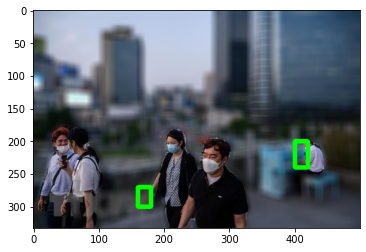

In [ ]:
img_third = combine_img_dict['high'].copy()
img_third_img = cv2.rectangle(img_third,(400,200),(420,240),(0,255,0),6)
img_third_img = cv2.rectangle(img_third_img,(160,270),(180,300),(0,255,0),6)
plt.imshow(img_third_img)
plt.show()

문제점 : 표시영역 신체 일부가 배경으로 처리됨

## definition of problem and solving 



최종 환성된 이미지를 보면 문제점이 확연하게 드러난다. 가장 단순한 첫번째 사진은 거의 완벽에 가까운 segmentation의 결과를 보여준다. 하지만 2번째, 3번째 사진과 같이 다소 복잡한 이미지에서 이미지안의 사진 이미지가 배경으로 간주되지 않았고 신체의 말단 부분인 '손(hand)'부분을 배경으로 간주하는 섬세함의 문제점이 보인다. 최첨단 인공지능 기술에 속하는 deeplab모델이 색칠놀이 하는 6살 박에 안되는 어린이보다 섬세함과 인물 구분 능력이 떨어지는 이유에 대해 고찰해 볼 필요가 있다. 사람이 '인물'에 대해 학습할 때 시각적 정보만으로 학습하지 않는다. 시각이 주된 외부 정보 인지기관이지만 시각 외에 거리 감각을 갖는 촉각, 사람의 피부층을 보호하고 민감한 부분을 가릴 수 있는 의복을 입는다는 사실, 헤어스타일의 다양한 변화, 다양한 브랜드의 의복에 대한 사실 등 매우 많은 경험적 정보를 토대로 사진 속 인물을 '사람'으로 인지할 수 있다. 

이번 프로젝트에서는 단순히 2-dimension image의 정보만으로 인물을 구별지으려 하였다. 이미지 정보에서는 별도로 거리나 위치 정보가 담겨있지 않다. 이러한 한계에서 이미지 픽셀값으로 거리와 같은 인물을 추정(estimation)할 수 있는 정보들을 추론하고 보다 더 개선된 segmentation의 결과를 얻어야 한다. 이번 lms에서는 깊이(depth)에 힌트를 주었고 depth를 추정하는 방법과 다른 접근으로 문제를 해결해보려 한다.


## Problem solving method by "depth"

특수한 카메라 없이 플랫한 이미지를 통해 원근감을 추정하는 것은 segmentation의 정확도를 높이는데 일조할 것이다. 사물의 원근감의 정보는 원하는 class를 구분짓는 중요한 기준이 될 것이기 때문이다. 인물이 배경보다 앞에 있다는 정보를 알게 된다면 앞에 있는 모든 이미지를 하나의 클래스로 segmentation하면 된다. 하지만 플랫한 이미지 만으로 원근감을 추정하는 것은 매우 어렵다. 직관적으로 볼 때 나의 시점에서 어떤 물체가 대략 어느정도 가깝고 멀다의 정도는 사진에 따라 다르게 느껴지기 때문이다. 만약 사진이 정면에서 찍은 사진이라면 배경과 원하는 클래스의 거리를 추정하기 어렵다. 하지만 45도 정도의 일정의 각도에서 찍은 사진이라면 상대적 거리의 차이를 쉽게 추정할 수 있다. 

길다란 직사각형의 물체를 위에서 아래로 찍으면 뒷부분으로 갈수록 좁아지는 모양으로 찍힌다. 만약 사각형의 책상에서 찍은 물체에 대해서 segmentation을 하게 된다면 책상의 좁아지는 각도에 따라 물체의 원근감을 수학적으로 추정할 수 있다. lms에서 링크를 통해 본 영상 이미지들은 도로에서 촬영한 것들이다. 도로에서 촬영할 떄 양쪽 사이드의 도로는 먼 지역일수록 좁아진다. 따라서 멀고 가까운 것은 절대적인 거리를 알기 어려우나 상대적으로 도로의 기울기를 직선으로 삼아 상대적인 거리를 알 수 있다. 



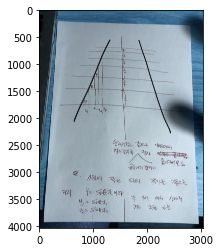

In [125]:
estimation_dist = cv2.imread('est.jpg')
plt.imshow(estimation_dist)
plt.show()

## Problem solving method - canny algorithm

위에서 segmentation의 문제점 중 하나는 경계의 모호성이다. 인물의 주된 특성을 잡아 배경과 인물을 구분짓는 성능은 좋으나 섬세한 요소들(hand,hair, 등)에 대해서 경계가 명확하지 않다. 이러한 불명확한 경계에 대해서 이미지의 엣지(edge)를 구분지어 segmentation의 영역을 명시적(explicit)으로 지정해 줄 필요가 있다. 마치 어린아이(특히 어린 여자아이)들이 엣지만 그려진 도화지에 각종 색연필로 색칠을 하듯 명확한 경계를 지정해주면 경계의 모호성을 해소할 수 있다. 

이러한 접근법에 기반으로 이미지의 경계면을 추출할 수 있는 기능을 갖는 라이브러리를 찾게 되었고 경계 추출에 많이 이용하고 있는 `canny algorithm`을 찾게 되었다. 아래 사진과 같이 canny algorithm은 경계면들을 잘 보여주고 있다. 이 경계면들은 deeplab이 인물을 추정하고 난 결과에 대해서 segmentation의 영역을 지정하여 경계의 모호성을 타개할 수 있을 것으로 여겨진다. 

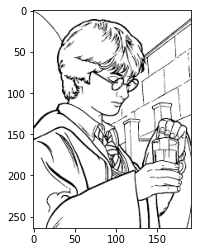

In [ ]:
edge_img_sample = cv2.imread('line_img.png')
plt.imshow(cv2.cvtColor(edge_img_sample, cv2.COLOR_BGR2RGB))
plt.show()

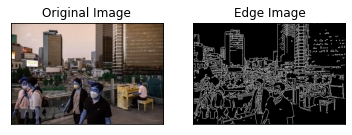

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = img_dict['high']
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

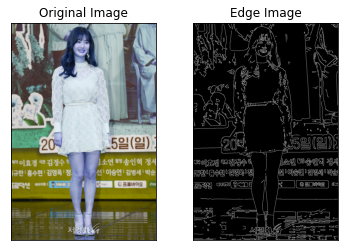

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img = img_dict['med']
edges = cv2.Canny(img,100,200)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

## Problem solving method - skeleton cognition
위 결과에서 또 다른 문제는 'person'근처에 관련없는 영역에 대한 segmentation이다. 2번째 '양혜지'의 mask 처리된 이미지를 보면 왼쪽에 조그마한 segmentation의 영역이 보인다. 이 영역은 deeplab model의 구체적인 알고리즘에 대해 분석하고 자세히 알지 못하여 어떤 요인으로 생겨난 문제인지 모르겠지만 이와 같은 문제를 해결하기 위해 인물의 특성과의 연관성을 추정할 수 있어야 한다. 사람의 형상은 각 사람의 관절의 모양에 의해 전체적인 모양을 추정한다. 그리고 관절의 각 부위의 지점에서 segmentation이 연속적이지 않을 경우 segmentation 영역이 아닐 가능성은 커진다. 연속적이지 않은 부분에 대해서 과감히 segementation의 영역이 아니라고 단정짓지 않는 이유는 사람의 신체 일부가 나무, 책상 등의 다른 물체에 의해 뒤에 가려졌을 상황을 고려하였기 때문이다. 만약 사람의 팔이 나뭇가지에 가려 연속적이지 않다고 해서 잘려보이는 팔은 여전히 그 사람의 신체 일부이다. 

연속적이지 않은 영역의 픽셀값(rgb)값이 가장 가까운 거리에 있는 관절 포인트 혹은 라인의 픽셀 주성분값의 범위안에 해당된다면 연속된 이미지로 여기고 segmentation을 수행한다. 이러한 수행은 물리적인 거리의 연관성과 픽셀값의 연관성 2가지를 고려하여 연속적이지 않은 이미지에 대한 신체적 연관성을 추정할 수 있다. (물론 구체적인 수치와 함수는 추후 생각해보아야 할 것이다.)

## Unresolved problem : 사진 속의 이미지는 사람인가 사람을 찍었던 사진인가?

2번째 사진에서 매우 흥미롭고 재미있는 생각이 들었다. deeplab model은 '양혜지' 오른편에 있는 할머니 사진을 사람이라고 판단하였다. 하지만 2번째 사진을 보는 나, 퍼실님(이 과제를 평가하는) 같은 사람들은 아마 모두가 사진 속 사진(할머니로 추정)이 사람이 아닌 사진 이미지라는 것을 안다. 현재 내가 보는 시점에서 양혜지는 실제 사람을 dslr으로 찍힌 것이고 할머니 사진은 실제 할머니가 찍힌것이 아닌 할머니를 찍은 사진을 dslr으로 찍은 것이다.

이것을 좀 더 추상적이고 명확하게 알기 위해서 함수로 추상화해보자! 인물을 촬영하는 dslr로 촬영하는 행위를 def Pic()라고 하자. 그렇다면 2번째 사진의 결과물은 다음과 같다.

이미지01 = Pic(양혜지,브로마이드,할머니사진)<br>
현장에 있던 양혜지와 포토그래퍼 시점에서 뒤에 걸려진 사진은 다음과 같다.<br>
이미지02 = Pic(할머니)<br>

deeplab model은 사진속의 사진이 현재 내가 보고 있는 시점에서 사람인지 그냥 사진인지 구분짓지 못하고 있다. 이것은 좀 더 고차원적인 convolution 기법으로 비선형적인 이미지의 특징들을 추출하고 그것이 사람인지 플랫한 사진 이미지인지 추정할 수 있어야 해결할 수 있을 것으로 생각된다. 


# In my opinion


사람은 기계가 어려워하는 이 매우 복잡하고 어려운 문제에 대해서 너무나 쉽게 사람과 사람을 찍은 사진으로 구분짓는다. 나는 인공지능을 공부할 때 마다 뇌의 신비함에 매료된다. 사람은 별 생각 없이 방구석에 나뒹굴면서 이것이 사진인지 아닌지 구분지을 수 있는데 기계는 왜 6살 짜리 아이보다 못할까? 반대로 사람은 왜 이렇게 우수한걸까? 

여러 학자들은 사람을 패턴의 동물이라고 한다. 사람의 경험으로부터 무의식적으로 학습한 것 중 일부는 기계보다 훨씬 효율적이고 우수하다. 하지만 우리는 어떻게 학습했는지 일일히 계산하고 평가하지 않는다. 직립보행할 때 사람은 무한히 실패를 경험한 끝에 능숙하게 뛰어다니고 묘기를 부리기까지 한다. 이 과정에서 사람은 약간의 스트레스만 느낄 뿐 의식적으로 일일이 평가하지 않아도 알아서 최적의 파라미터값을 찾아낸다. 사람은 의식적으로 오른쪽 앞발을 1cm디디면 오른쪽으로 약간 쓰러진다는 느낌을 안다. 하지만 이를 구체적으로 gradient값을 산출하지 않는다. 그냥 대체적으로 이정도 기울이면 기울이는 반대 방향으로 힘을 가하면 된다의 식으로 감각으로 습득한다. 그리고 습득 과정에서 다양한 감각기관들의 정보들을 기억한다. 시각, 촉각, 달팽이관의 수평감각 등을 의식적으로든 무의식적으로든 기억을 축적한다.

이러한 사람의 학습 방식에 대해서 사진 속 이미지가 사진인지 인물인지 구분짓는 문제를 보고 다양한 감각 정보들의 복합성이 필요하다고 느꼈다. 단지 시각 이미지로 사람을 구별짓는 것은 대단히 어렵다. 만약 사람이 감각 기관 중 시각만 있었다면 지금과 같이 사진 속 이미지가 사람인지 사진인지 구별할 수 있었을까? 그리고 그렇게 학습할 수 있었을까?

사진을 보고 양혜지가 입은 옷이 어떤 옷인지 여성분들은 자신의 경험을 통해 촉각, 핏, 색감 등의 다양한 정보들을 추상할 수 있다. 이러한 점으로 볼 때 촉각의 경험, 옷에 대한 경험, 신발에 대한 경험 등 다양한 경험들의 정보가 개입된다면 보다 더 개선된 인지능력을 갖춘 모델을 만들 수 있지 않을까? 

